# MNIST handwritten digit classification
# Homework 0 of MLDS course (2017 summer, NTU)

In [1]:
### Import modules ###

import numpy as np
import tensorflow as tf
import struct
import csv
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
### Load data ###

train_images_idx3 = '/home/andrewkgs/MLDS2017/hw0/train-images-idx3-ubyte'
train_labels_idx1 = '/home/andrewkgs/MLDS2017/hw0/train-labels-idx1-ubyte'
test_images_idx3 = '/home/andrewkgs/MLDS2017/hw0/test-image'

proportion = 0.80 # Determine how many datasets are used for training and validation, respectively.

def decode_idx3_ubyte(idx3_ubyte_file):
  bin_data = open(idx3_ubyte_file, 'rb').read()
  offset = 0
  fmt_header = '>iiii'
  magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)

  image_size = num_rows * num_cols
  offset += struct.calcsize(fmt_header)
  fmt_image = '>' + str(image_size) + 'B'
  images = np.empty((num_images, num_rows, num_cols))
  for i in range(num_images):
    images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
    offset += struct.calcsize(fmt_image)
  return images


def decode_idx1_ubyte(idx1_ubyte_file):
  bin_data = open(idx1_ubyte_file, 'rb').read()
  offset = 0
  fmt_header = '>ii'
  magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)

  offset += struct.calcsize(fmt_header)
  fmt_image = '>B'
  labels = np.empty(num_images)
  for i in range(num_images):
    labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
    offset += struct.calcsize(fmt_image)
  return labels


def load_train_images(idx_ubyte_file = train_images_idx3):
  return decode_idx3_ubyte(idx_ubyte_file)

def load_train_labels(idx_ubyte_file = train_labels_idx1):
  return decode_idx1_ubyte(idx_ubyte_file)

def load_test_images(idx_ubyte_file = test_images_idx3):
  return decode_idx3_ubyte(idx_ubyte_file)

if __name__ == '__main__':
  train_images_data = load_train_images()
  train_labels_data = load_train_labels()
  test_images_data = load_test_images()

  data_size = len(train_images_data)
  train_size = int(data_size * proportion)

  train_dataset = train_images_data[:train_size,:,:]
  train_labels = train_labels_data[:train_size]
  valid_dataset = train_images_data[train_size:,:,:]
  valid_labels = train_labels_data[train_size:]
  test_dataset = test_images_data

  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape)

Training set (48000, 28, 28) (48000,)
Validation set (12000, 28, 28) (12000,)
Test set (10000, 28, 28)


In [3]:
image_size = 28
num_labels = 10
num_channels = 1

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
def reformat_test(dataset):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset= reformat_test(test_dataset)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape)

Training set (48000, 28, 28, 1) (48000, 10)
Validation set (12000, 28, 28, 1) (12000, 10)
Test set (10000, 28, 28, 1)


## Graph & Model

In [4]:
batch_size = 512
patch_size = 3
depth = 16
num_hidden = 64
beta = 1e-6

starting_learning_rate = 0.0017

num_steps = 0

graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, 2 * depth], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[2 * depth]))
    layer4_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, 2 * depth, 3 * depth], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[3 * depth]))
    layer5_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * (3 * depth), num_hidden], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer6_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


    # Model.
    def model(data, train=True):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, layer3_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer3_biases)
        conv = tf.nn.conv2d(hidden, layer4_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer4_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer5_weights) + layer5_biases)
        if (train):
            hidden = tf.nn.dropout(hidden, 0.75)
        return tf.matmul(hidden, layer6_weights) + layer6_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

    regularization = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) +
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights) +
                    tf.nn.l2_loss(layer5_weights) + tf.nn.l2_loss(layer6_weights))
    loss = loss + (beta * regularization)
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        starting_learning_rate,  # Base learning rate.
        batch * batch_size,  # Current index into the dataset.
        4000,  # Decay step.
        0.7,  # Decay rate.
        staircase=True)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, 0.5).minimize(loss, global_step=batch)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, False))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, False))

## Session

In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def run(num_steps):
    interval = 50
    y = []
    z = []
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print('\t minibatch \t minibatch \t validation')
        print('Steps \t loss \t\t accuracy \t accuracy')
        print('---------------------------------------------------')
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 200 == 0):
                print('%d\t %f\t %.3f %%\t %.3f %%\t' % (
                step,
                l,
                accuracy(predictions, batch_labels),
                accuracy(valid_prediction.eval(), valid_labels)
                ))

            if (step % interval == 0):
                y.append(accuracy(predictions, batch_labels))
                z.append(accuracy(valid_prediction.eval(), valid_labels))

        x = np.arange(0, num_steps, interval)
        plt.plot(x, y, 'r', label='train')
        plt.plot(x, z, 'b', label='validation')
        plt.xlabel("step")
        plt.ylabel("accuracy (%)")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()

        """
        test_labels = np.argmax(test_prediction.eval(), 1)

        f = open('prediction.csv', 'w', encoding= 'UTF-8')
        w = csv.writer(f)
        csvHeader = ['id', 'label']
        w.writerow(csvHeader)
        for i in range(0, len(test_labels)):
            result=[[i,test_labels[i]]]
            w.writerows(result)  
        f.close()
        del f
        """

	 minibatch 	 minibatch 	 validation
Steps 	 loss 		 accuracy 	 accuracy
---------------------------------------------------
0	 32.284233	 12.109 %	 12.992 %	
200	 0.297364	 91.406 %	 95.967 %	
400	 0.120037	 96.289 %	 97.725 %	
600	 0.128114	 95.508 %	 98.233 %	
800	 0.133818	 96.094 %	 98.442 %	
1000	 0.071305	 97.266 %	 98.675 %	
1200	 0.046634	 98.438 %	 98.792 %	
1400	 0.036034	 99.023 %	 98.725 %	
1600	 0.036538	 98.438 %	 98.808 %	
1800	 0.032133	 99.023 %	 98.850 %	
2000	 0.012873	 99.805 %	 98.925 %	
2200	 0.012837	 99.414 %	 98.892 %	
2400	 0.025925	 98.633 %	 98.942 %	
2600	 0.032627	 98.828 %	 99.008 %	
2800	 0.017245	 99.219 %	 98.825 %	
3000	 0.029498	 99.023 %	 98.833 %	
3200	 0.009405	 99.609 %	 98.850 %	
3400	 0.028731	 99.219 %	 98.950 %	
3600	 0.016669	 99.609 %	 98.883 %	
3800	 0.015640	 99.609 %	 98.975 %	
4000	 0.043082	 99.414 %	 98.950 %	
4200	 0.014701	 99.414 %	 98.958 %	
4400	 0.015926	 99.609 %	 98.983 %	
4600	 0.011262	 99.414 %	 98.867 %	
4800	 0.011958	 9

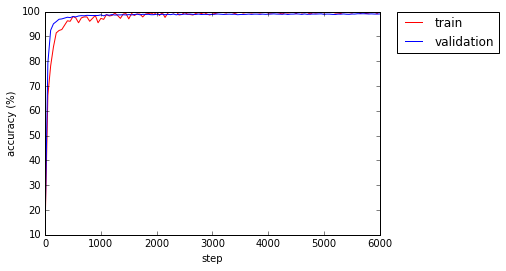

In [6]:
run(6001)